In [1]:
from music21 import midi as midi21 
from music21 import stream
import copy
import music21
import soundfile as sf
from __future__ import division 
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import wavfile
import scipy
from scipy import signal
import librosa
%matplotlib inline
import IPython.display as ipydisplay
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torchaudio
import pandas as pd
import tensorflow as tf
import numpy as np
from torchvision import transforms

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.2.0)/charset_normalizer (2.0.10) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2023-09-05 20:25:42.290724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#select train data_set, 6000 samples, each speaker repeats each digit 10 times
train_data = []
for people in range(1,61):
    if people<10: str_people = "0"+str(people)
    else: str_people = str(people)
    for digit in range(0,10):
        for num in range (0,10):
            file_path = "data/"+str_people+"/"+str(digit)+"_"+str_people+"_"+str(num)+".wav"
            train_data.append(file_path)

test_data = []
for people in range(1,61):
    if people<10: str_people = "0"+str(people)
    else: str_people = str(people)
    for digit in range(0,10):
        for num in range (10,14):
            file_path = "data/"+str_people+"/"+str(digit)+"_"+str_people+"_"+str(num)+".wav"
            test_data.append(file_path)

In [3]:
max_length = max(len(librosa.load(filename)[0]) for filename in train_data)
max_length

22047

In [4]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.04):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_diffusion_sample(x_0, t):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t * x_0 \
    + sqrt_one_minus_alphas_cumprod_t * noise, noise


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [5]:
# perform logarithmic scale mel-spectrogram
filename = train_data[0]

def extract_mel_spec(filename):
    n_fft = 1024  
    hop_length = 512  
    n_mels = 64 
    max_length = 22047
    y, sr = librosa.load(filename)
    y_padded = np.pad(y, (0, max_length - len(y)))
    filter_banks = librosa.filters.mel(n_fft = n_fft, sr = 22050, n_mels=n_mels)
    mel_spectrogram = librosa.feature.melspectrogram(y=y_padded, sr = sr, n_fft = n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

In [11]:
import numpy as np

# Your original input data as a NumPy ndarray
original_data = np.random.randn(1, 3, 64, 44)

# Define the desired output shape
desired_shape = (1, 3, 64, 64)

# Calculate the amount of padding needed for the width dimension
pad_width = desired_shape[3] - original_data.shape[3]

# Create a tuple for the pad_width with (left, right) padding for the width dimension
pad_width_tuple = ((0, 0), (0, 0), (0, 0), (0, pad_width))

# Use np.pad to add zero padding to the width dimension
padded_data = np.pad(original_data, pad_width_tuple, mode='constant')

print("Original shape:", original_data.shape)
print("Padded shape:", padded_data.shape)


# To remove the padding and get back to the original shape:
# Calculate the amount of padding added to the width dimension
pad_width = 20

# print(padded_data.shape[3] , original_data.shape[3])
# # Use slicing to remove the padding from the width dimension
original_data_restored = padded_data[:, :, :, :-pad_width]

print("Restored original shape:", original_data_restored.shape)

Original shape: (1, 3, 64, 44)
Padded shape: (1, 3, 64, 64)
Restored original shape: (1, 3, 64, 44)


In [12]:
def display_mel_spec(log_mel_spectrogram,min_val,max_val):
    if torch.is_tensor(log_mel_spectrogram) == True:
        log_mel_spectrogram = log_mel_spectrogram.numpy()    
    #unpad data
    pad_width = 20
    log_mel_spectrogram = log_mel_spectrogram[:, :, :, :-pad_width]

    if len(log_mel_spectrogram.shape) == 4: 
        log_mel_spectrogram = log_mel_spectrogram[0, 0, :, :]
    # plt.figure(figsize = (10,5))
    librosa.display.specshow(log_mel_spectrogram , cmap='viridis', vmin=min_val, vmax=max_val)
    # plt.colorbar(format = "%+2.f")
    # plt.show()

In [13]:

def pad_data(input_matrix):
    mel_spec_reshape = np.expand_dims(np.expand_dims(input_matrix, axis=0), axis=1)
    # print(mel_spec_reshape.shape)
    mel_spec_reshape = np.repeat(mel_spec_reshape, 3, axis=1)
    # print(mel_spec_reshape.shape)
    original_data = mel_spec_reshape
    desired_shape = (1, 3, 64, 64)
    pad_width = desired_shape[3] - original_data.shape[3]
    pad_width_tuple = ((0, 0), (0, 0), (0, 0), (0, pad_width))
    padded_data = np.pad(original_data, pad_width_tuple, mode='constant')
    return padded_data

In [14]:
#def get_dataset()
train_dataset = train_data
for ind in range(len(train_data)):
    mel_spec = extract_mel_spec(train_data[ind])
    # mel_spec_reshape = np.expand_dims(mel_spec,0)
    mel_spec_reshape = pad_data(mel_spec)

    train_dataset[ind] = torch.from_numpy(mel_spec_reshape)
test_dataset = test_data
for ind in range(len(test_data)):
    mel_spec = extract_mel_spec(test_data[ind])
    mel_spec_reshape = pad_data(mel_spec)
    # mel_spec_reshape = np.expand_dims(np.expand_dims(mel_spec, axis=0), axis=1)
    # # mel_spec_reshape = np.expand_dims(mel_spec,0)
    
    # mel_spec_reshape = np.repeat(mel_spec_reshape, 3, axis=1)
    test_dataset[ind] = torch.from_numpy(mel_spec_reshape)

# data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
# dataloader = DataLoader(data, shuffle=True, drop_last=True)

In [15]:
data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
dataloader = DataLoader(data, batch_size=1, shuffle=True, drop_last=True)
sample = next(iter(dataloader))[0]
sample.shape

torch.Size([1, 3, 64, 64])

torch.Size([1, 3, 64, 64])


/var/folders/69/hpgc4yf52cnd1fjvl3nkxzym0000gn/T/ipykernel_18046/2444111441.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


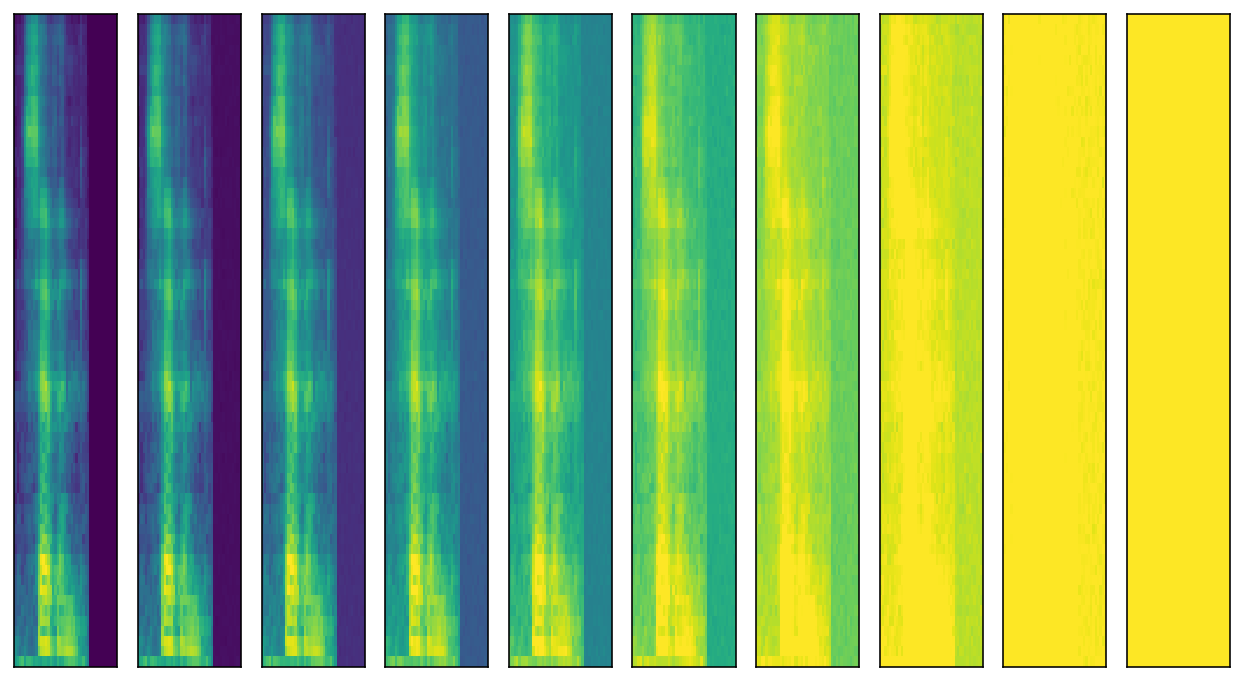

In [17]:
# sample of a forward diffusion

num_images = 10
stepsize = int(T/num_images)
sample = next(iter(dataloader))[0]
print(sample.shape)
plt.figure(figsize=(12,6))
plt.axis('off')
if torch.is_tensor(sample) == True:
    sample_spectrogram = sample.numpy() 

pad_width = 20
sample_spectrogram = sample_spectrogram[:, :, :, :-pad_width]

if len(sample_spectrogram.shape) == 4: 
    sample_spectrogram = sample_spectrogram[0, 0, :, :]


min_val = sample_spectrogram.flatten().min()
max_val = sample_spectrogram.flatten().max()
librosa.display.specshow(sample_spectrogram, cmap='viridis', vmin=min_val, vmax=max_val)
cbar = plt.colorbar(format='%+2.0f')


for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(sample, t)
    display_mel_spec(img, min_val, max_val)
    # display_mel_spec(img)
    
# plt.tight_layout()
plt.show()

In [276]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu  = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c,out_c)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x,p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size = 2, stride = 2, padding = 0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        # I padded all inputs, so shape should not be a problem
        x = self.up(inputs)
        x = torch.cat([x,skip], axis = 1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        '''encoder'''
        self.e1 = encoder_block(3,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)

        '''bottleneck'''
        self.b = conv_block(512,1024)

        '''decoder'''
        self.d1 = decoder_block(1024,512)
        self.d2 = decoder_block(512,256)
        self.d3 = decoder_block(256,128)
        self.d4 = decoder_block(128,64)
        
        '''classifier'''
        self.outputs = nn.Conv2d(64,1,kernel_size=1, padding =0)
            
    def forward(self, inputs):
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.b(p4)

        d1 = self.d1(b,s4)
        d2 = self.d2(d1,s3)
        d3 = self.d3(d2,s2)
        d4 = self.d4(d3,s1)

        outputs = self.outputs(d4)
        return outputs


if __name__ == "__main__":
    # input shape [batch, channel, height, width]
    # inputs = torch.randn((1,3,64,64))
    inputs = next(iter(dataloader))[0]

    # e = encoder_block(3,64)
    # x,p = e(inputs)
    # print(x.shape, p.shape)
    # c=conv_block(3,64)
    # c(inputs)
    # inputs = torch.randn((2,64,512,512))
    # skip = torch.randn((2,32,512,512))
    # d = decoder_block(64,32)
    # x=d(inputs, skip)
    # print(x.shape)
    model = build_unet()
    y = model(inputs)
    print(y.shape)


torch.Size([1, 1, 64, 64])


In [18]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        # device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [19]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [20]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

In [24]:
from torch.optim import Adam
BATCH_SIZE = 1
# device = "cuda" if torch.cuda.is_available() else "cpu"
model
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,)).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        # display_mel_spec(img, min_val, max_val)

Epoch 0 | step 000 Loss: 0.351713091135025 


KeyboardInterrupt: 